## Testing Levenshtein distance and PHATE on tsv files
1. Pull tsv data into your favorite dataframe
2. Run through Lev distance to get adjacency matrix
3. <s>Combine adjacency matrix and original dataframe</s> No need, PHATE can take just the matrix
4. Pass to PHATE

In [ ]:
# Install necessary packages into the Google Collab notebook
!pip install python-Levenshtein
!pip install phate 

     |████████████████████████████████| 51kB 3.1MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149811 sha256=e530fbfdfcf0f9055eef0fdccde5812c843859f580ec1d7a24504b25840912f0
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein
     |████████████████████████████████| 112kB 7.9MB/s 
     |████████████████████████████████| 419kB 31.6MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 1.8MB 31.6MB/s 


In [ ]:
# Importing favorite packages
from Levenshtein import ratio, distance # https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html#Levenshtein-ratio
import phate
import pandas as pd
import numpy as np 
import os



---


### Grabbing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Peek to see if file is there
file_paths = ["/content/drive/MyDrive/Team 1/Covid_Vaccine_6fbca1da-1a25-4848-ae35-eaffc6bb392b/IHCV2020-020.IHCV2020-020-Spikepos-Mem-B-1TP.pooled.tsv", 
              "/content/drive/MyDrive/Team 1/Covid_Vaccine_6fbca1da-1a25-4848-ae35-eaffc6bb392b/IHCV2020-020.IHCV2020-020-Spikepos-Mem-B-2TP.pooled.tsv", 
              "/content/drive/MyDrive/Team 1/Covid_Vaccine_6fbca1da-1a25-4848-ae35-eaffc6bb392b/IHCV2020-020.IHCV2020-020-Spikepos-Mem-B-4TP.pooled.tsv"]
for file in file_paths : assert os.path.isfile(file), "File {} doesn't exist or isn't readable".format(file)

In [ ]:
# Combine data across tsvs's 
frames = [] 

for file in file_paths : 
  frames.append(pd.read_csv(file, sep = '\t'))

# Adding timepoint markers to files
timepoints = [1, 2, 4]
for i in range(len(frames)) : 
  frames[i]['timepoint'] = timepoints[i]

data = pd.concat(frames)

In [ ]:
# Take a peek at our loaded data
data.head()

,Unnamed: 0,clone_id,subject,v_gene,j_gene,functional,insertions,deletions,cdr3_nt,cdr3_num_nts,cdr3_aa,uniques,instances,copies,germline,parent_id,avg_v_identity,top_copy_seq,timepoint
0,2,254989,IHCV2020-020,IGHV1-18,IGHJ5,T,NaN,NaN,TGTGCGAGGAGGGGAATAGGTCGAAACGACCCCTGG,36,CARRGIGRNDPW,972,833,2036,CAGGTTCAGCTGGTGCAGTCTGGAGCT---GAGGTGAAGAAGCCTG...,NaN,0.9356,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1
1,690,426166,IHCV2020-020,IGHV4-59,IGHJ3,T,NaN,NaN,TGTGCGAGGTTTGGTATTACCATGGTAGTGGTCGACGATGCTTTTG...,54,CARFGITMVVVDDAFDLW,569,576,1793,CAGGTGCAGCTGCAGGAGTCGGGCCCA---GGACTGGTGAAGCCTT...,NaN,0.8917,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1
2,331,260919,IHCV2020-020,IGHV1-2,IGHJ5,T,NaN,NaN,TGTGCGAGATCCTCTGAGGGGAGTGGCCCCTGGGTCTGGTTCGACC...,51,CARSSEGSGPWVWFDPW,739,744,1789,CAGGTGCAGCTGGTGCAGTCTGGGGCT---GAGGTGAAGAAGCCTG...,NaN,0.9621,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1
3,443,302176,IHCV2020-020,IGHV3-21,IGHJ5,T,NaN,NaN,TGTGCGAGACACGCTACAGGAATTACGGATTGCTGGTTCGACCCCTGG,48,CARHATGITDCWFDPW,754,771,1616,GAGGTGCAGCTGGTGGAGTCTGGGGGA---GGCCTGGTCAAGCCTG...,NaN,0.9564,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1
4,660,404050,IHCV2020-020,IGHV4-31,IGHJ5,T,NaN,NaN,TGTGCGAATCATAGGGCTTGGAGAGGGGGGTTCGACTCCTGG,42,CANHRAWRGGFDSW,575,585,1592,CAGGTGCAGCTGCAGGAGTCGGGCCCA---GGACTGGTGAAGCCTT...,NaN,0.9549,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1




---


### Creating Adjacency Matrix using Edit-Distance

In [ ]:
# Simple loop through cdr3_aa to create distances

# Make our adj matrix first
num_clones = len(data.index)
print("Using", num_clones, "rows")
adj_matrix = np.zeros((num_clones, num_clones))

# Make a simple reference list of sequences instead of having to access the dataframe
seqs = data.loc[:,'cdr3_aa'].values

import time
start = time.time()
for i in range(num_clones) : 
  for j in range(num_clones) : 
    # adj_matrix[i][j] = max(0, (ratio(seqs[i], seqs[j])-0.45)**2) # by thresholded + stretched levenshtein "ratio"/similarity
    adj_matrix[i][j] = distance(seqs[i], seqs[j]) # by levenshtein "ratio"/similarity
    # if adj_matrix[i][j] != 0.0 : adj_matrix[i][j] += 0.5
    # adj_matrix[i][j] = distance(seqs[i], seqs[j]) # by levenshtein distance
print("Took", time.time()-start, "seconds")

Using 2346 rows
Took 6.651402473449707 seconds


In [ ]:
# Take a peek at the adj matrix
adj_matrix

array([[ 0., 11.,  9., ..., 10., 12., 14.],
       [11.,  0., 12., ..., 14., 14., 10.],
       [ 9., 12.,  0., ..., 13., 13., 13.],
       ...,
       [10., 14., 13., ...,  0., 11., 16.],
       [12., 14., 13., ..., 11.,  0., 15.],
       [14., 10., 13., ..., 16., 15.,  0.]])



---
### Test PHATE


In [26]:
phate_operator = phate.PHATE(knn=15, decay=20, t=150, knn_dist='precomputed')
Y_phate = phate_operator.fit_transform(adj_matrix)

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 2346 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.62 seconds.
  Calculated graph and diffusion operator in 0.72 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.78 seconds.
    Calculating KMeans...
    Calculated KMeans in 27.60 seconds.
  Calculated landmark operator in 30.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 5.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.57 seconds.
Calculated PHATE in 44.48 seconds.


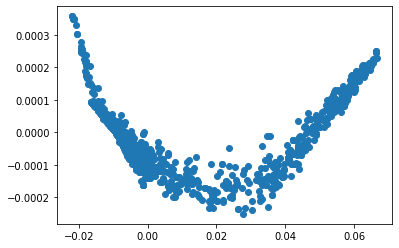

In [27]:
# Take a peek at the coords
import matplotlib.pyplot as plt
plt.scatter(Y_phate[:,0], Y_phate[:,1])

In [ ]:
# Save our coords along with all the data
data['phate1'] = Y_phate[:,0]
data['phate2'] = Y_phate[:,1]

data.to_csv("all_timepoints_phate.tsv", sep="\t", index=False)

In [29]:
# RUN MANY PHATE FITS FOR DIFFERENT PARAMETERS
# Going to change the timesteps for the diffusion operator
possible_t = [10*n for n in range(1, 16)]

for test_t in possible_t : 
  phate_operator = phate.PHATE(knn=15, decay=20, t=test_t, knn_dist='precomputed')
  Y_phate = phate_operator.fit_transform(adj_matrix)
  data['phate_x_' + str(test_t)] = Y_phate[:,0]
  data['phate_y_' + str(test_t)] = Y_phate[:,1]

data.to_csv("all_timepoints_multi_phate.tsv", sep="\t", index=False)

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 2346 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.63 seconds.
  Calculated graph and diffusion operator in 0.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.78 seconds.
    Calculating KMeans...
    Calculated KMeans in 19.42 seconds.
  Calculated landmark operator in 21.93 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 8.63 seconds.
Calculated PHATE in 33.46 seconds.
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 2346 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.61 seconds.
  Calculated graph and diffusion operator in 0.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
  

In [ ]:
data.head() # Double check

,Unnamed: 0,clone_id,subject,v_gene,j_gene,functional,insertions,deletions,cdr3_nt,cdr3_num_nts,cdr3_aa,uniques,instances,copies,germline,parent_id,avg_v_identity,top_copy_seq,timepoint,phate1,phate2
0,2,254989,IHCV2020-020,IGHV1-18,IGHJ5,T,NaN,NaN,TGTGCGAGGAGGGGAATAGGTCGAAACGACCCCTGG,36,CARRGIGRNDPW,972,833,2036,CAGGTTCAGCTGGTGCAGTCTGGAGCT---GAGGTGAAGAAGCCTG...,NaN,0.9356,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1,-0.011571,-0.003692
1,690,426166,IHCV2020-020,IGHV4-59,IGHJ3,T,NaN,NaN,TGTGCGAGGTTTGGTATTACCATGGTAGTGGTCGACGATGCTTTTG...,54,CARFGITMVVVDDAFDLW,569,576,1793,CAGGTGCAGCTGCAGGAGTCGGGCCCA---GGACTGGTGAAGCCTT...,NaN,0.8917,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1,-0.010989,-0.002568
2,331,260919,IHCV2020-020,IGHV1-2,IGHJ5,T,NaN,NaN,TGTGCGAGATCCTCTGAGGGGAGTGGCCCCTGGGTCTGGTTCGACC...,51,CARSSEGSGPWVWFDPW,739,744,1789,CAGGTGCAGCTGGTGCAGTCTGGGGCT---GAGGTGAAGAAGCCTG...,NaN,0.9621,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1,-0.010439,0.001696
3,443,302176,IHCV2020-020,IGHV3-21,IGHJ5,T,NaN,NaN,TGTGCGAGACACGCTACAGGAATTACGGATTGCTGGTTCGACCCCTGG,48,CARHATGITDCWFDPW,754,771,1616,GAGGTGCAGCTGGTGGAGTCTGGGGGA---GGCCTGGTCAAGCCTG...,NaN,0.9564,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1,-0.012105,-0.000646
4,660,404050,IHCV2020-020,IGHV4-31,IGHJ5,T,NaN,NaN,TGTGCGAATCATAGGGCTTGGAGAGGGGGGTTCGACTCCTGG,42,CANHRAWRGGFDSW,575,585,1592,CAGGTGCAGCTGCAGGAGTCGGGCCCA---GGACTGGTGAAGCCTT...,NaN,0.9549,NNNNNNNNNNNNNNNNNNNNNNNNNNN---NNNNNNNNNNNNNNNN...,1,-0.009778,-0.003369


(array([4.500000e+03, 1.024000e+03, 8.320000e+02, 1.768000e+03,
        6.268000e+03, 2.415000e+04, 2.637480e+05, 3.577920e+05,
        5.374280e+05, 6.670800e+05, 7.383500e+05, 7.333260e+05,
        1.164888e+06, 3.787340e+05, 2.511220e+05, 1.596860e+05,
        1.008680e+05, 5.878200e+04, 4.452000e+04, 5.992000e+03,
        2.052000e+03, 6.140000e+02, 1.660000e+02, 2.000000e+01,
        6.000000e+00]),
 array([ 0.  ,  1.16,  2.32,  3.48,  4.64,  5.8 ,  6.96,  8.12,  9.28,
        10.44, 11.6 , 12.76, 13.92, 15.08, 16.24, 17.4 , 18.56, 19.72,
        20.88, 22.04, 23.2 , 24.36, 25.52, 26.68, 27.84, 29.  ]),
 <a list of 25 Patch objects>)

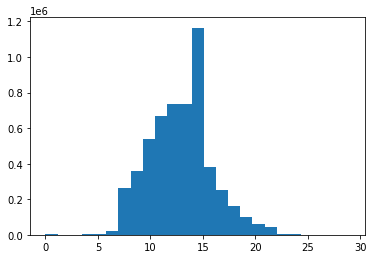

In [ ]:
plt.hist(adj_matrix.flatten(), 25)

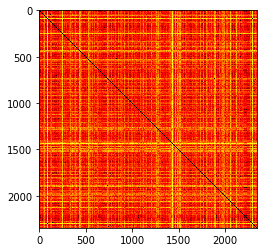

In [ ]:
plt.imshow(adj_matrix, cmap='hot', interpolation='nearest')
plt.show()

(array([  1.,  14.,  97., 525., 621., 583., 352., 124.,  25.,   4.]),
 array([ 4. ,  6.8,  9.6, 12.4, 15.2, 18. , 20.8, 23.6, 26.4, 29.2, 32. ]),
 <a list of 10 Patch objects>)

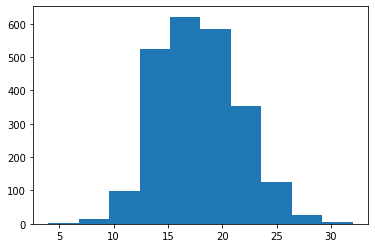

In [ ]:
# Cdr3 length distribution 
plt.hist([len(i) for i in seqs])

PHATE graph probably looks as expected, with similarities in strings